# Clustering to determine optimal Food Groups
As early as 1917, the US Department of Agriculture (USDA) has publicized different groupings of food.  There are currently six food groups that the USDA groups all food products in:
 1. Bread, cereal, rice, and pasta, 
 2. Vegetables,  
 3. Fruits, 
 4. Milk, yogurt, and cheeses, 
 5. Meat, poultry, fish, dry beans, eggs, and nuts and 
 6. Fats, oils, and sweets 
 These groups have been organized based on "nutritional objectives and to moderate intake of those components related to risk of chronic diseases" (Dietary Recommendations and How They Have Changed Over Time, Davis & Saltos). 

For this project, I am looking to determine if the current number of six food groups (last updated in 1993) is the optimal grouping based on nutritional similarities.  The objective of the analysis is to determine an optimal model to cluster food groups based on nutritional data and verify that the same food products should remain grouped together. 

## Importing Libraries needed for the analysis

In [1]:
# Data processing 
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Dataset
from sklearn import datasets

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Modeling
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture

# Hypertuning Metrics and Parameters
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

# Surpress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Loading the Data of 8600+ food products and their associated nutritional attributes

In [2]:
# Load data
data = pd.read_csv('Nutritions_US.csv', encoding='latin-1')
data.head(5)

,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),...,Vit_D_IU,Vit_K_(¾g),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2
0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,...,0.0,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp
1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,...,0.0,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp
2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,...,0.0,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup
3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,...,21.0,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch
4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,...,22.0,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded"


In [3]:
data.shape

(8790, 52)

## Intial Exploratory Data Analysis

In [4]:
# Group columns by data type
grouped = data.columns.to_series().groupby(data.dtypes).groups

for dtype, columns in grouped.items():
    print(f"Columns with data type {dtype}: {', '.join(columns)}")

Columns with data type int64: NDB_No, Energ_Kcal
Columns with data type float64: Water_(g), Protein_(g), Lipid_Tot_(g), Ash_(g), Carbohydrt_(g), Fiber_TD_(g), Sugar_Tot_(g), Calcium_(mg), Iron_(mg), Magnesium_(mg), Phosphorus_(mg), Potassium_(mg), Sodium_(mg), Zinc_(mg), Copper_mg), Manganese_(mg), Selenium_(¾g), Vit_C_(mg), Thiamin_(mg), Riboflavin_(mg), Niacin_(mg), Panto_Acid_mg), Vit_B6_(mg), Folate_Tot_(¾g), Folic_Acid_(¾g), Food_Folate_(¾g), Folate_DFE_(¾g), Choline_Tot_ (mg), Vit_B12_(¾g), Vit_A_IU, Vit_A_RAE, Retinol_(¾g), Alpha_Carot_(¾g), Beta_Carot_(¾g), Beta_Crypt_(¾g), Lycopene_(¾g), Lut+Zea_ (¾g), Vit_E_(mg), Vit_D_¾g, Vit_D_IU, Vit_K_(¾g), FA_Sat_(g), FA_Mono_(g), FA_Poly_(g), Cholestrl_(mg), GmWt_1, GmWt_2
Columns with data type object: Shrt_Desc, GmWt_Desc1, GmWt_Desc2


Since the majority (47) of the columns are floats, lets focus on how we will be handling the non-float columns. 

For the integer columns, since **NDB_No* is primary key for the database I will keep it for identification purposes but not for clustering purposes. Since *Energ_KCal* is a numeric column I can convert it to a float. 

For the object columns, I will keep *Shrt_Desc* for identification purposes but not for clustering purposes, and remove *GmWt_Desc1* and *GmWt_Desc2* since the text in the columns is needed for the nutritional analysis.

In [5]:
# Drop the NDB_No, and GmWt_Desc1 and GmWt_Desc2 columns and convert the int64 column to float
data['Energ_Kcal'] = data['Energ_Kcal'].astype(float)
df=data.drop(['NDB_No', 'GmWt_Desc1', 'GmWt_Desc2'], axis=1)

#### Missing Values



In [6]:
# Columns with a null value
columns_with_nan = df.columns[df.isna().any()]
df[columns_with_nan].isna().sum() 

Water_(g)               1
Ash_(g)               325
Fiber_TD_(g)          594
Sugar_Tot_(g)        1832
Calcium_(mg)          348
Iron_(mg)             144
Magnesium_(mg)        739
Phosphorus_(mg)       579
Potassium_(mg)        426
Sodium_(mg)            83
Zinc_(mg)             706
Copper_mg)           1257
Manganese_(mg)       2160
Selenium_(¾g)        1700
Vit_C_(mg)            818
Thiamin_(mg)          634
Riboflavin_(mg)       616
Niacin_(mg)           637
Panto_Acid_mg)       2242
Vit_B6_(mg)           905
Folate_Tot_(¾g)      1261
Folic_Acid_(¾g)      2039
Food_Folate_(¾g)     1768
Folate_DFE_(¾g)      2057
Choline_Tot_ (mg)    4016
Vit_B12_(¾g)         1193
Vit_A_IU              711
Vit_A_RAE            1535
Retinol_(¾g)         1806
Alpha_Carot_(¾g)     3258
Beta_Carot_(¾g)      3162
Beta_Crypt_(¾g)      3270
Lycopene_(¾g)        3292
Lut+Zea_ (¾g)        3315
Vit_E_(mg)           2889
Vit_D_¾g             3262
Vit_D_IU             3211
Vit_K_(¾g)           3563
FA_Sat_(g)  

In [7]:
print('Out of the {} columns, {} have empty or null values'
      .format(df.shape[1], len(df[columns_with_nan].isna().sum())) )

Out of the 49 columns, 44 have empty or null values


Normally, the number of columns and the amount of nans in the columns would be very concerning. Since this data involves nutritional content of a variety of foods, it is reasonable to assume the nans are due to the lack of significant amounts of the various nutrients and thus can be replaced with 0 values. 

In [8]:
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Shrt_Desc          8790 non-null   object 
 1   Water_(g)          8790 non-null   float64
 2   Energ_Kcal         8790 non-null   float64
 3   Protein_(g)        8790 non-null   float64
 4   Lipid_Tot_(g)      8790 non-null   float64
 5   Ash_(g)            8790 non-null   float64
 6   Carbohydrt_(g)     8790 non-null   float64
 7   Fiber_TD_(g)       8790 non-null   float64
 8   Sugar_Tot_(g)      8790 non-null   float64
 9   Calcium_(mg)       8790 non-null   float64
 10  Iron_(mg)          8790 non-null   float64
 11  Magnesium_(mg)     8790 non-null   float64
 12  Phosphorus_(mg)    8790 non-null   float64
 13  Potassium_(mg)     8790 non-null   float64
 14  Sodium_(mg)        8790 non-null   float64
 15  Zinc_(mg)          8790 non-null   float64
 16  Copper_mg)         8790 

### Numerical summary of the columns/features

In [9]:
df.iloc[:, 1:].describe()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_E_(mg),Vit_D_¾g,Vit_D_IU,Vit_K_(¾g),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2
count,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,...,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000
mean,54.106061,226.317634,11.342849,10.553725,1.717527,22.127710,2.039625,6.762531,73.700114,2.655447,...,0.893890,0.364300,14.591809,9.295370,3.434338,3.771797,2.115612,38.718885,93.105193,137.640216
std,30.776516,169.877539,10.530474,15.814842,2.967679,27.270822,4.267904,13.723474,200.017998,5.651177,...,3.853351,3.091688,123.670680,62.125274,6.426162,6.825884,5.050857,117.353035,84.713057,309.447941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.692500,91.000000,2.380000,0.950000,0.770000,0.050000,0.000000,0.000000,8.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.149000,0.074250,0.134250,0.000000,28.350000,0.000000
50%,63.080000,191.000000,8.000000,5.140000,1.170000,9.340000,0.400000,0.490000,19.000000,1.325000,...,0.120000,0.000000,0.000000,0.000000,1.435500,1.600000,0.591500,2.000000,85.000000,15.000000
75%,77.960000,337.000000,19.880000,13.720000,2.020000,34.910000,2.400000,6.057500,64.000000,2.570000,...,0.470000,0.000000,1.000000,1.900000,4.173750,4.759000,1.880000,65.000000,128.000000,186.000000
max,100.000000,902.000000,88.320000,100.000000,99.800000,100.000000,79.000000,99.800000,7364.000000,123.600000,...,149.400000,250.000000,10000.000000,1714.500000,95.600000,83.689000,74.623000,3100.000000,1184.000000,5717.000000


Let's look at the correlations between the numeric columns.

In [10]:
float_columns = [x for x in df.columns if x not in ['Shrt_Desc']]

# The correlation matrix
corr_mat = df[float_columns].corr()

# Strip out the diagonal values for the next step
for x in range(len(float_columns)):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_E_(mg),Vit_D_¾g,Vit_D_IU,Vit_K_(¾g),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2
Water_(g),0.000000,-0.900535,-0.103833,-0.489584,-0.235744,-0.774010,-0.385601,-0.457883,-0.237414,-0.349057,...,-0.231762,-0.057984,-0.057947,0.020771,-0.367960,-0.390598,-0.399317,0.055348,0.396132,0.147064
Energ_Kcal,-0.900535,0.000000,0.112636,0.806677,0.083260,0.493028,0.202065,0.315796,0.124892,0.196225,...,0.303858,0.074981,0.074914,-0.024115,0.619119,0.676569,0.595191,0.015090,-0.389617,-0.088113
Protein_(g),-0.103833,0.112636,0.000000,0.062336,0.106315,-0.304295,-0.074143,-0.269321,0.046245,0.128590,...,-0.028482,0.018185,0.018243,-0.071973,0.052530,0.094276,-0.039389,0.290245,-0.149047,0.193043
Lipid_Tot_(g),-0.489584,0.806677,0.062336,0.000000,-0.005906,-0.048594,-0.023089,-0.000276,0.016833,-0.035627,...,0.337699,0.073140,0.073059,0.015055,0.764603,0.868514,0.703962,0.087229,-0.256681,0.003930
Ash_(g),-0.235744,0.083260,0.106315,-0.005906,0.000000,0.119708,0.179003,0.006669,0.474304,0.197636,...,0.054890,0.022577,0.022641,0.062480,-0.023510,-0.001901,0.016658,-0.006389,-0.130826,-0.049805
Carbohydrt_(g),-0.774010,0.493028,-0.304295,-0.048594,0.119708,0.000000,0.455710,0.617259,0.189064,0.344312,...,0.072081,0.014612,0.014592,-0.011403,-0.043835,-0.096127,0.054849,-0.219735,-0.220803,-0.232494
Fiber_TD_(g),-0.385601,0.202065,-0.074143,-0.023089,0.179003,0.455710,0.000000,0.107561,0.233700,0.380423,...,0.153374,-0.011303,-0.011272,0.155161,-0.075663,-0.030789,0.073603,-0.145824,-0.076920,-0.148700
Sugar_Tot_(g),-0.457883,0.315796,-0.269321,-0.000276,0.006669,0.617259,0.107561,0.000000,0.125703,0.113846,...,0.066531,0.054585,0.054501,-0.014826,0.068650,-0.063346,-0.005232,-0.136263,-0.148557,-0.139017
Calcium_(mg),-0.237414,0.124892,0.046245,0.016833,0.474304,0.189064,0.233700,0.125703,0.000000,0.351912,...,0.116558,0.067348,0.067380,0.171640,0.034857,-0.008598,0.010034,-0.037233,-0.108749,-0.081314
Iron_(mg),-0.349057,0.196225,0.128590,-0.035627,0.197636,0.344312,0.380423,0.113846,0.351912,0.000000,...,0.166128,0.080535,0.080755,0.175387,-0.052289,-0.035025,0.002011,0.005995,-0.187737,-0.085940


<Axes: >

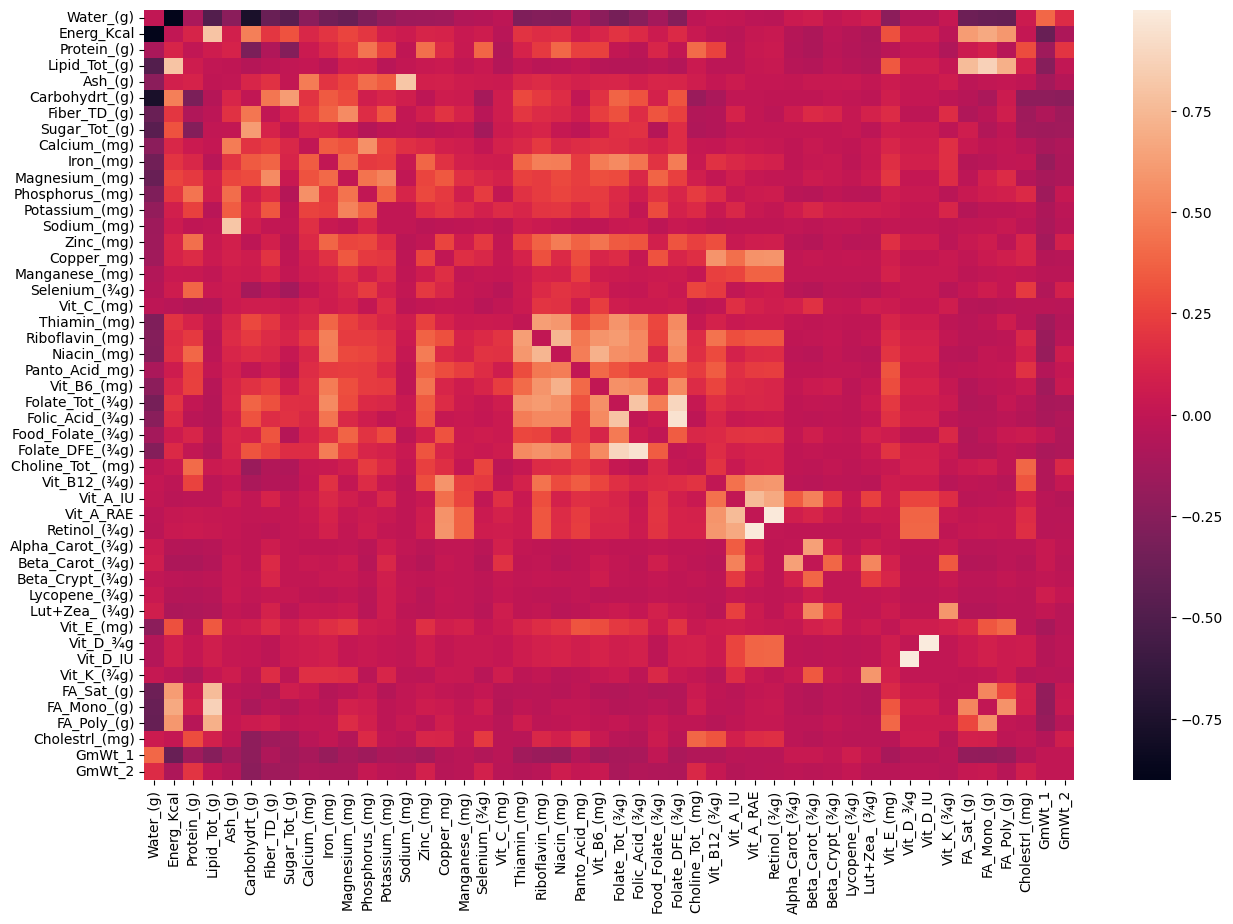

In [11]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(corr_mat)

We don't see many highly correlated features with the exceptions of a few pairings (Water and Energy, Water and Carbohydrates, Vit_D_3/4g and Vid_D_IU, Retional and Vit_A, Folate_DFE and Folate_Acid). 

Now lets look at the skewness of the attribute distributions.

In [12]:
skew_columns = (df[float_columns]
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
print("{} of the 47 columns are skewed with the vast majority being heavily skewed".format(len(skew_columns)))
skew_columns

47 of the 47 columns are skewed with the vast majority being heavily skewed


Vit_D_¾g             61.111488
Vit_D_IU             61.105802
Manganese_(mg)       40.433711
Beta_Crypt_(¾g)      38.667063
Selenium_(¾g)        38.441668
Vit_C_(mg)           29.549434
Alpha_Carot_(¾g)     29.098417
Retinol_(¾g)         25.313237
Vit_A_RAE            24.355932
Lycopene_(¾g)        24.246488
Sodium_(mg)          22.513287
Beta_Carot_(¾g)      19.196363
Phosphorus_(mg)      18.530683
Thiamin_(mg)         18.149933
Ash_(g)              17.017930
Copper_mg)           16.362549
Vit_K_(¾g)           16.293227
Choline_Tot_ (mg)    15.672419
Potassium_(mg)       15.590756
Vit_A_IU             15.456607
Cholestrl_(mg)       15.322793
Panto_Acid_mg)       14.853265
Vit_E_(mg)           13.700820
Calcium_(mg)         13.432410
Lut+Zea_ (¾g)        13.356796
Vit_B12_(¾g)         13.212239
Food_Folate_(¾g)     13.045058
Riboflavin_(mg)      11.772537
Folic_Acid_(¾g)      10.927219
Folate_DFE_(¾g)      10.546925
Zinc_(mg)             9.593906
Folate_Tot_(¾g)       8.944269
Vit_B6_(

Since the attributes are skewed and possess different scales, I'll do a log transform and peform feature scaling to prepare the data for the models.

In [13]:
# Perform log transform on skewed columns
for col in skew_columns.index.tolist():
    df[col] = np.log1p(df[col])

In [14]:
# Perform feature scaling  using a Standard Scaler
sc = StandardScaler()
df[float_columns] = sc.fit_transform(df[float_columns])

df.describe()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_E_(mg),Vit_D_¾g,Vit_D_IU,Vit_K_(¾g),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2
count,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,...,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03
mean,3.411252e-16,-1.766252e-16,2.635232e-16,9.033350e-17,1.131695e-16,8.083535e-18,-2.950490e-17,2.101719e-16,1.406535e-16,-1.147862e-16,...,2.910073e-17,-2.425061e-18,2.020884e-16,-9.700242e-18,-1.519705e-16,-2.134053e-16,-1.616707e-18,1.649041e-16,-3.039409e-16,-3.880097e-17
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,...,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-1.758131e+00,-5.078130e+00,-1.915338e+00,-1.495841e+00,-1.695331e+00,-1.323316e+00,-8.355773e-01,-8.200624e-01,-2.071709e+00,-1.307576e+00,...,-5.785349e-01,-3.400762e-01,-5.061267e-01,-6.266014e-01,-1.135562e+00,-1.107065e+00,-9.396471e-01,-9.547157e-01,-3.333763e+00,-1.017361e+00
25%,-7.932981e-01,-5.449261e-01,-7.759399e-01,-9.317373e-01,-5.437054e-01,-1.293105e+00,-8.355773e-01,-8.200624e-01,-6.276376e-01,-7.378398e-01,...,-5.785349e-01,-3.400762e-01,-5.061267e-01,-6.266014e-01,-9.803793e-01,-1.031195e+00,-7.735848e-01,-9.547157e-01,-5.517354e-01,-1.017361e+00
50%,2.916006e-01,1.926380e-01,1.403020e-01,3.710858e-02,-1.327610e-01,1.231212e-01,-4.237345e-01,-5.098541e-01,-1.028383e-01,-1.220323e-01,...,-3.754099e-01,-3.400762e-01,-5.061267e-01,-6.266014e-01,-1.410018e-01,-9.488839e-02,-3.270855e-01,-4.147510e-01,3.333112e-01,5.522485e-02
75%,7.751136e-01,7.596162e-01,9.276405e-01,7.756852e-01,5.338939e-01,8.940084e-01,6.623267e-01,7.000267e-01,6.718032e-01,4.805602e-01,...,1.119916e-01,-3.400762e-01,-1.975960e-02,2.704733e-01,7.008177e-01,7.475251e-01,4.547878e-01,1.104487e+00,6.671133e-01,1.006312e+00
max,1.491285e+00,1.744774e+00,2.287418e+00,2.402471e+00,7.609042e+00,1.534314e+00,4.528034e+00,2.768503e+00,3.780548e+00,5.472390e+00,...,8.407069e+00,1.333279e+01,5.956649e+00,5.648275e+00,3.971113e+00,3.595168e+00,4.762798e+00,2.996665e+00,2.492839e+00,2.329453e+00


In [15]:
df[float_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Water_(g)          8790 non-null   float64
 1   Energ_Kcal         8790 non-null   float64
 2   Protein_(g)        8790 non-null   float64
 3   Lipid_Tot_(g)      8790 non-null   float64
 4   Ash_(g)            8790 non-null   float64
 5   Carbohydrt_(g)     8790 non-null   float64
 6   Fiber_TD_(g)       8790 non-null   float64
 7   Sugar_Tot_(g)      8790 non-null   float64
 8   Calcium_(mg)       8790 non-null   float64
 9   Iron_(mg)          8790 non-null   float64
 10  Magnesium_(mg)     8790 non-null   float64
 11  Phosphorus_(mg)    8790 non-null   float64
 12  Potassium_(mg)     8790 non-null   float64
 13  Sodium_(mg)        8790 non-null   float64
 14  Zinc_(mg)          8790 non-null   float64
 15  Copper_mg)         8790 non-null   float64
 16  Manganese_(mg)     8790 

In [16]:
# Takes a long time (40+ minutes) to complete
#sns.set_context('notebook')
#sns.pairplot(df[float_columns])

### Extract the float columns to be used as the Input (X) data for the Clustering models

In [17]:
X = df[float_columns]

## Clustering Models 
Using various clustering methods (K-Means, Hiearchichal Agglomerative and Gaussian Mixture Model ), I will use hypertuning to find the optimal number of clusters of the data. I will use the Silhouette score metrics to compare the results of each optimal cluster.

In [18]:
# Trackers throughout each model
optimal_clusters={} # to track the optimal number of clusters
scores = {} # to track the silhoutte score of the tuned model
food_groups = {} # to track the counts of each group

### K Means Clustering
First, lets determine the optimal number of clusters based on inertia values and silhouette scores. I am consider the number of clusters to test between relatively close (+/- 2) to the current number of food groupings of 6.

In [19]:
inertia = {}
silhouette = {}
list_num_clusters = list(range(4,8))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    # For Elbow Method comparison
    inertia[num_clusters]=km.inertia_
    # For Silhouette 
    # Make prediction
    classes = km.predict(X)
    silhouette[num_clusters] = (silhouette_score(X, classes)) 

Text(0.5, 1.0, 'Silhouette Score by Number of Clusters')

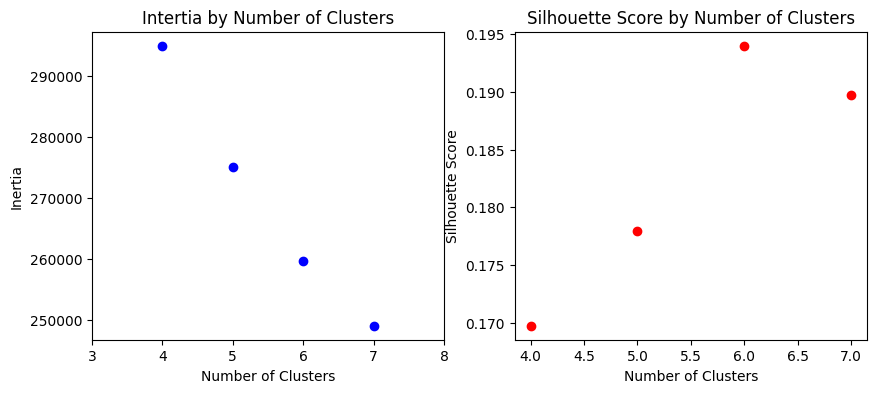

In [20]:
# Creating subplots with 1 row and 2 columns to plot the inertia and silhouette scores per k
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(list(inertia.keys()),list(inertia.values()), color='blue', label='Elbow Meethod')
ax1.set_xlabel('Number of Clusters')
ax1.set_xticks(range(3,9))
ax1.set_ylabel('Inertia')
ax1.set_title('Intertia by Number of Clusters')

ax2.scatter(list(silhouette.keys()),list(silhouette.values()), color='red', label='Silhoutte Meethod')
ax2.set_xlabel('Number of Clusters')
ax1.set_xticks(range(3,9))
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by Number of Clusters')

From the elbow method and the silhouette score, it is clear that 6 clusters is the ideal number of clusters as it shows where the concavity changes for the inertia vs cluster number graph and it has the highest silhouette score.

In [21]:
optimal_clusters['kmeans']= max(silhouette, key=lambda k: silhouette[k])
km = KMeans(n_clusters=optimal_clusters['kmeans'])
km.fit(X)
df['K-Means'] = km.predict(X)
scores['K-Means'] = (silhouette_score(X, df['K-Means']))


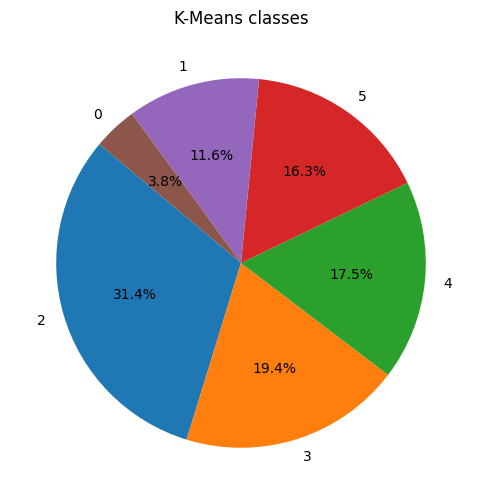

In [23]:
# Check the distribution
value_counts = df['K-Means'].value_counts()
plt.figure(figsize=(6, 6))  
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('K-Means classes')
plt.show()

In [24]:
# Keep track of the amount of foods in each group
food_groups['K-Means'] = value_counts.sort_values(ascending=False)

## Hierarchical Clustering via Agglomerative Clustering

In [25]:
# Define a range of parameters for AgglomerativeClustering to fine tune the parameters
param_grid = {
    'n_clusters': [4,5,6,7,8],
    'linkage': ['complete', 'average', 'single'],
    'affinity' : ['euclidean', 'manhattan', 'cosine']
}

best_score = -1
best_params = {}
silhouettescores = []

# Perform grid search for hyperparameter tuning
for params in ParameterGrid(param_grid):
    agglomerative = AgglomerativeClustering(**params)
    cluster_labels = agglomerative.fit_predict(X)
    silhouette = silhouette_score(X, cluster_labels)
    silhouettescores.append(silhouette)
    if silhouette > best_score:
        best_score = silhouette
        best_params = params

print("Best silhouette score:", best_score)
print("Best parameters:", best_params)

Best silhouette score: 0.531017857624702
Best parameters: {'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 4}


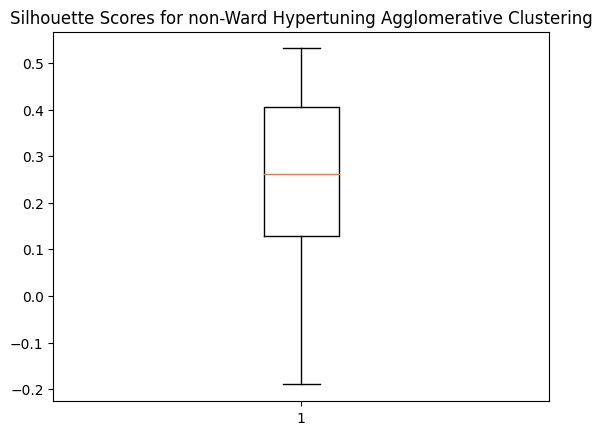

In [26]:
plt.boxplot(silhouettescores)
plt.title('Silhouette Scores for non-Ward Hypertuning Agglomerative Clustering')
plt.show()

Optimal Agglomerative Clustering without considering the ward linkage leads to the optimal number of clusters being the smallest option. Let's see what the cluster groups look like for this "optimal" tuning.

In [27]:
agg = AgglomerativeClustering(n_clusters=best_params['n_clusters'], 
                            affinity=best_params['affinity'], 
                           linkage=best_params['linkage'])
agg = agg.fit(X)
df['agg_non_ward_optimal'] = agg.fit_predict(X)
df['agg_non_ward_optimal'].value_counts()

agg_non_ward_optimal
0    8786
1       2
2       1
3       1
Name: count, dtype: int64

Extremely unbalanced with four clusters, even though the silhouette score was the highest for these parameters. Lets look at the results when I use the ward linkage and euclidean distance metric, but vary the cluster number.

In [28]:
# Define a range of parameters for AgglomerativeClustering to fine tune the parameters
param_grid = {
    'n_clusters': [4,5,6,7,8],
    'linkage': ['ward'],
    'affinity' : ['euclidean']
}

best_score = -1
best_params = {}
silhouettescores = []

# Perform grid search for hyperparameter tuning
for params in ParameterGrid(param_grid):
    agglomerative = AgglomerativeClustering(**params)
    cluster_labels = agglomerative.fit_predict(X)
    silhouette = silhouette_score(X, cluster_labels)
    silhouettescores.append(silhouette)
    if silhouette > best_score:
        best_score = silhouette
        best_params = params

print("Best silhouette score:", best_score)
print("Best parameters:", best_params)

Best silhouette score: 0.1713557480055047
Best parameters: {'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 6}


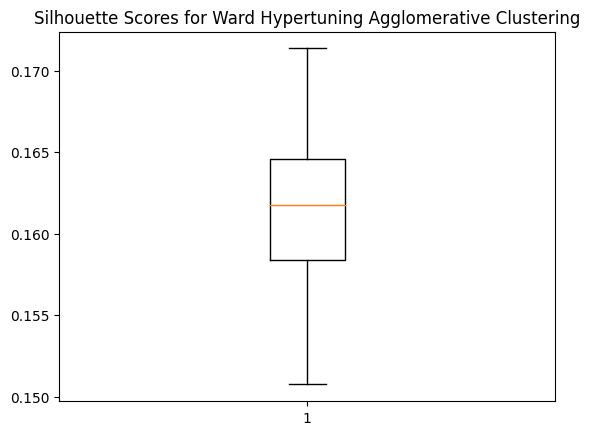

In [29]:
plt.boxplot(silhouettescores)
plt.title('Silhouette Scores for Ward Hypertuning Agglomerative Clustering')
plt.show()

In [31]:
agg_6 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
agg_6 = agg_6.fit(X)
df['Agglomerative'] = agg_6.fit_predict(X)
scores['Agglomerative'] = (silhouette_score(X, df['Agglomerative']))

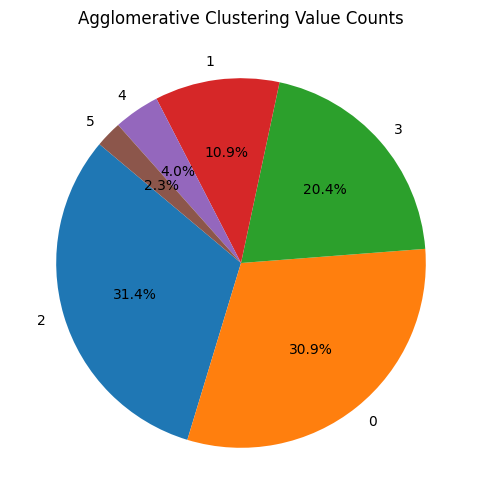

In [32]:
# Check the distribution
value_counts = df['Agglomerative'].value_counts()
food_groups['Agglomerative'] = value_counts.sort_values(ascending=False) # Added 
plt.figure(figsize=(6, 6)) 
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Agglomerative Clustering Value Counts')
plt.show()

Although the silhouette score was significantly lower when using the ward linkage, the optimal number of six clusters was the same result as K means.

In [33]:
optimal_clusters['Agglomerative']=best_params['n_clusters']

## Gaussian Mixture  Model (GMM)

In [34]:
# Define a range of parameters for GMM
param_grid = {
    'n_components': [4,5,6,7,8],
    'n_init' : [1,2,3,4,5,6]
}

best_score = -1
best_params = {}
silhouettes = []

# Perform grid search for hyperparameter tuning
for params in ParameterGrid(param_grid):
    gmm_model = GaussianMixture(**params)
    cluster_labels = gmm_model.fit_predict(X)
    silhouette = silhouette_score(X, cluster_labels)
    silhouettes.append(silhouette)
    if silhouette > best_score:
        best_score = silhouette
        best_params = params

print("Best silhouette score:", best_score)
print("Best parameters:", best_params)

Best silhouette score: 0.12658500966061575
Best parameters: {'n_components': 6, 'n_init': 5}


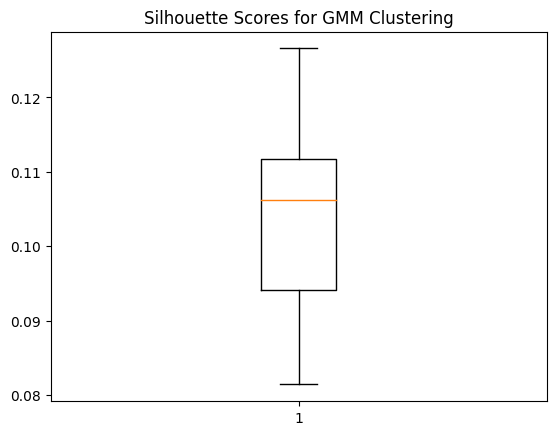

In [35]:
plt.boxplot(silhouettes)
plt.title('Silhouette Scores for GMM Clustering')
plt.show()

In [36]:
# Fit the GMM
gmm = GaussianMixture(n_components=best_params['n_components'], n_init=best_params['n_init'])

# Fit and predict on the data
df['GMM'] = gmm.fit_predict(X)
scores['GMM'] = (silhouette_score(X, df['GMM']))

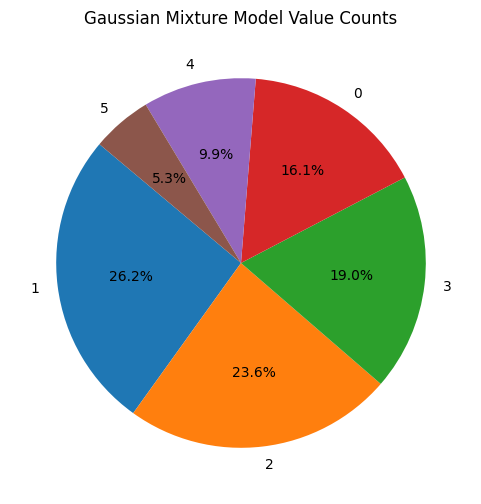

In [37]:
# Check the distribution
value_counts = df['GMM'].value_counts()
food_groups['GMM'] = value_counts.sort_values(ascending=False) # Added 
plt.figure(figsize=(6, 6))  # Adjust the figure size if needed
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gaussian Mixture Model Value Counts')
plt.show()

In [38]:
optimal_clusters['GMM']=best_params['n_components']

# Comparison of Models

In [39]:
# Extract keys and values from the dictionary
keys = list(food_groups.keys())
values = list(food_groups.values())
for key in keys:
    print(key + ' Method')
    i = 1
    for value in food_groups[key]:
        print('\tGroup {} has {} items ({:.0f}%)'.format(i, value, 100*value/data.shape[0]))
        i=i+1
    


kmeans Method
	Group 1 has 2756 items (31%)
	Group 2 has 1706 items (19%)
	Group 3 has 1537 items (17%)
	Group 4 has 1433 items (16%)
	Group 5 has 1020 items (12%)
	Group 6 has 338 items (4%)
Agglomerative Method
	Group 1 has 2762 items (31%)
	Group 2 has 2717 items (31%)
	Group 3 has 1796 items (20%)
	Group 4 has 959 items (11%)
	Group 5 has 353 items (4%)
	Group 6 has 203 items (2%)
GMM Method
	Group 1 has 2303 items (26%)
	Group 2 has 2071 items (24%)
	Group 3 has 1671 items (19%)
	Group 4 has 1412 items (16%)
	Group 5 has 870 items (10%)
	Group 6 has 463 items (5%)


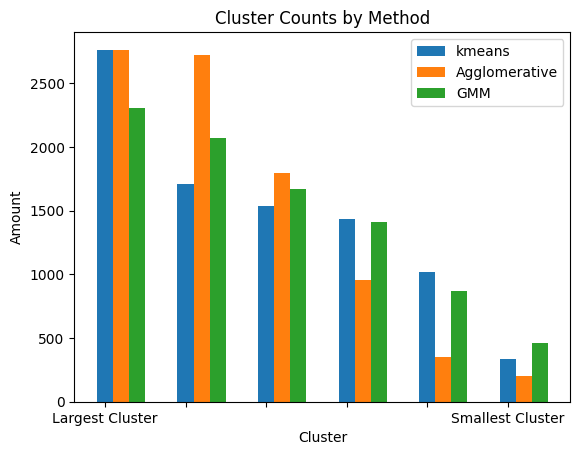

In [40]:
# Create a bar plot for each key
for i in range(len(keys)):
    plt.bar([j + i * 0.2 for j in range(len(values[i]))], values[i], width=0.2, align='center', label=keys[i])

plt.xlabel('Cluster')
plt.ylabel('Amount')
plt.title('Cluster Counts by Method')
plt.xticks([0,1,2,3,4,5], ['Largest Cluster', '', '', '', '', 'Smallest Cluster'])  
plt.legend()
plt.show()

### Compare using the Silhouette scores


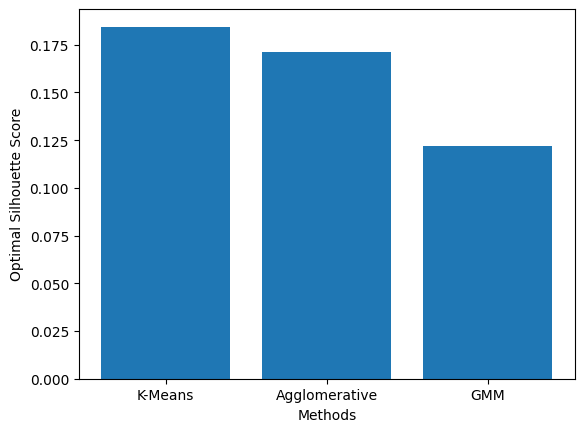

In [44]:
s_keys = list(scores.keys())
s_values = scores.values()

plt.bar(s_keys, s_values)
plt.xlabel('Methods')
plt.ylabel('Optimal Silhouette Score')
plt.show()

In [42]:
s_values

dict_values([K-Means
2    2756
3    1706
4    1537
5    1433
1    1020
0     338
Name: count, dtype: int64, Agglomerative
2    2762
0    2717
3    1796
1     959
4     353
5     203
Name: count, dtype: int64, GMM
1    2303
2    2071
3    1671
0    1412
4     870
5     463
Name: count, dtype: int64])